cuML TfidfVectorizer 과 cuML KNN 을 이용하여, title, image 가 주어졌을 때 비슷한 아이템을 분류하자.

TfidifVectorizer를 이용하여 item title에서 text feature embedding 추출하고 KNN을 이용하여 비교.

그리고 EffNetB0를 이용하여 item embeddings 추출 후 RAPID 와 비교해보려 한다.

### Load Library

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2, matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pytesseract
from tensorflow.keras.applications import EfficientNetB0
print('TF',tf.__version__)

TF 2.4.1


In [2]:
# RESTRICT TENSORFLOW TO 12GB OF GPU RAM
# SO THAT WE HAVE GPU RAM FOR RAPIDS CUML KNN
LIMIT = 12
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
print('Restrict TensorFlow to max %iGB GPU RAM'%LIMIT)
print('so RAPIDS can use %iGB GPU RAM'%(16-LIMIT))

2 Physical GPUs, 2 Logical GPUs
Restrict TensorFlow to max 12GB GPU RAM
so RAPIDS can use 4GB GPU RAM


### Load Train Data

In [3]:
#csv files
path = '/mnt/hdd1/wearly/kaggle/shopee/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sample = pd.read_csv(path + 'sample_submission.csv')

#Images Files
train_jpg_directory = path + 'train_images/'
test_jpg_directory = path + 'test_images/'

In [4]:
print('train shape is', train.shape )
train.head()

train shape is (34250, 5)


posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069

### Display random items from Data

In [5]:
path + 'train_images/0000a68812bc7e98c42888dfb1c07da0.jpg'

'/mnt/hdd1/wearly/kaggle/shopee/train_images/0000a68812bc7e98c42888dfb1c07da0.jpg'

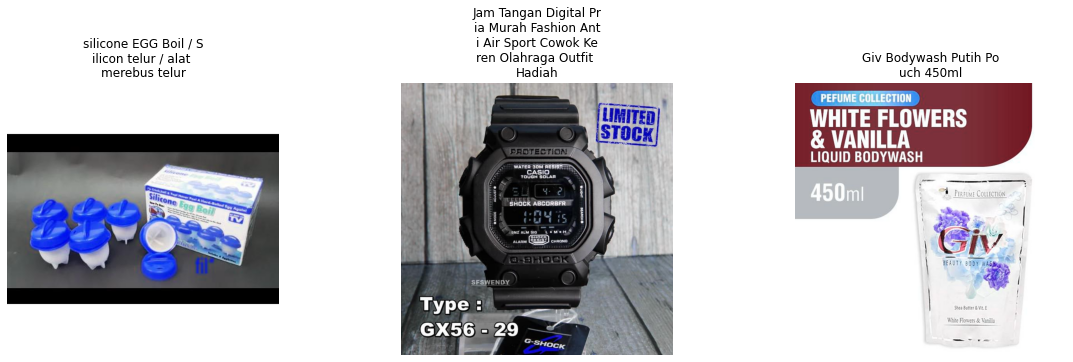

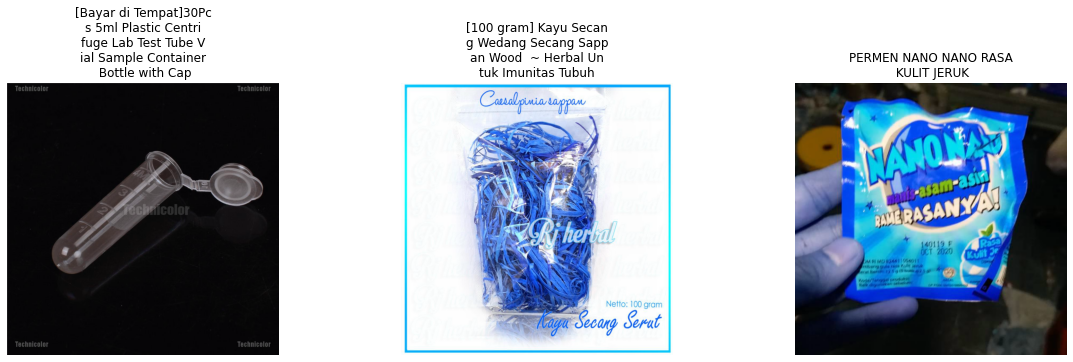

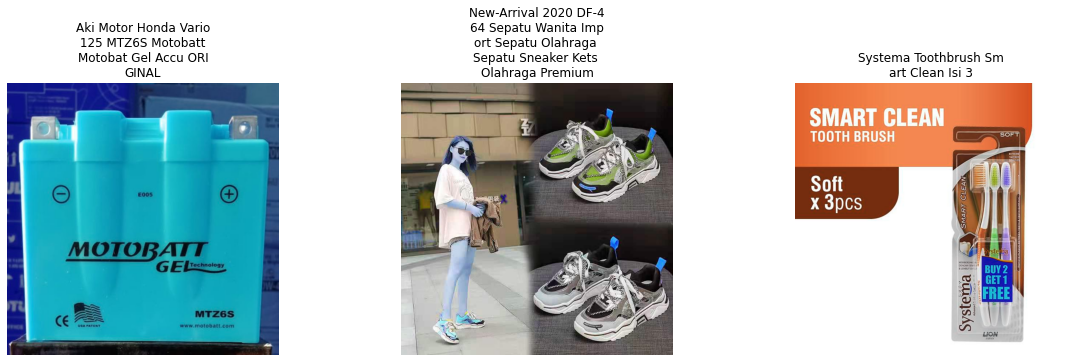

In [20]:
def displayDF(train, random=False, cols=3,rows=3, path=train_jpg_directory):
    for k in range(rows):
        plt.figure(figsize=(20,5))
        for j in range(cols):
            if random: row = np.random.randint(0,len(train))
            else: row = cols*k + j #?
            name = train.iloc[row,1] #image
            title = train.iloc[row,3] #title
            title_with_return = ""
            for i,ch in enumerate(title):
                title_with_return += ch
                if (i!=0)&(i%20==0): title_with_return += '\n' #20번째 row마다 줄바꿈
            img = cv2.imread(path+name)
            plt.subplot(1,cols,j+1)
            plt.title(title_with_return)
            plt.axis('off')
            plt.imshow(img)
        plt.show()

displayDF(train,random=True)

## Display Duplicated Items from Train Data¶


label_group 컬럼을 이용하여 group군 별로 이미지가 몇장씩 있는지 살펴보자

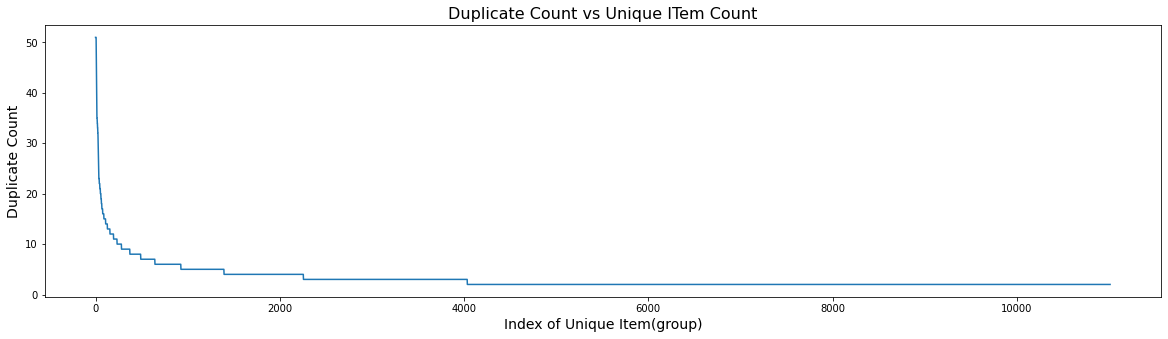

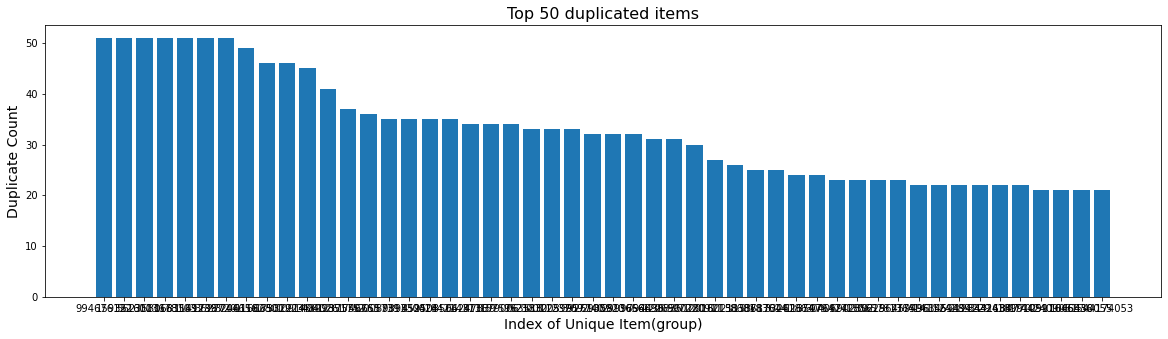

In [7]:
groups = train.label_group.value_counts()
plt.figure(figsize = (20,5))
plt.plot(np.arange(len(groups)), groups.values)
plt.ylabel('Duplicate Count', size=14)
plt.xlabel('Index of Unique Item(group)', size=14)
plt.title('Duplicate Count vs Unique ITem Count', size=16)
plt.show()

plt.figure(figsize=(20,5))
plt.bar(groups.index.values[:50].astype('str'), groups[:50].values)
plt.ylabel('Duplicate Count', size=14)
plt.xlabel('Index of Unique Item(group)', size=14)
plt.title('Top 50 duplicated items', size=16)
plt.show()

In [8]:
train.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069

########################################
Top1 DUPLICATED ITEM : 994676122


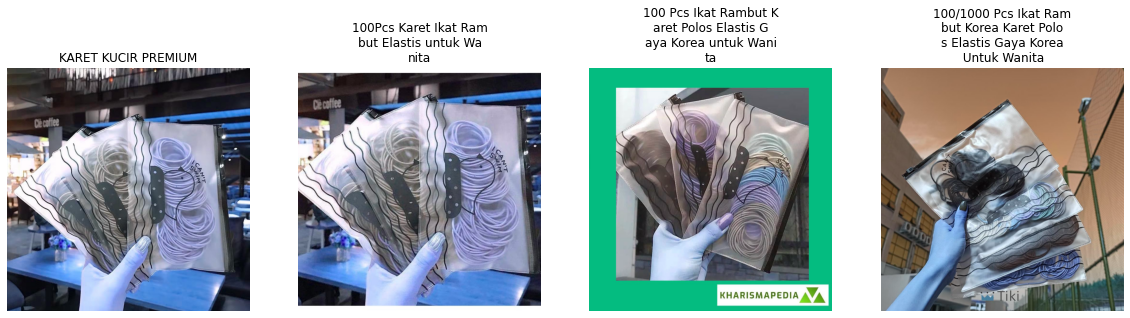

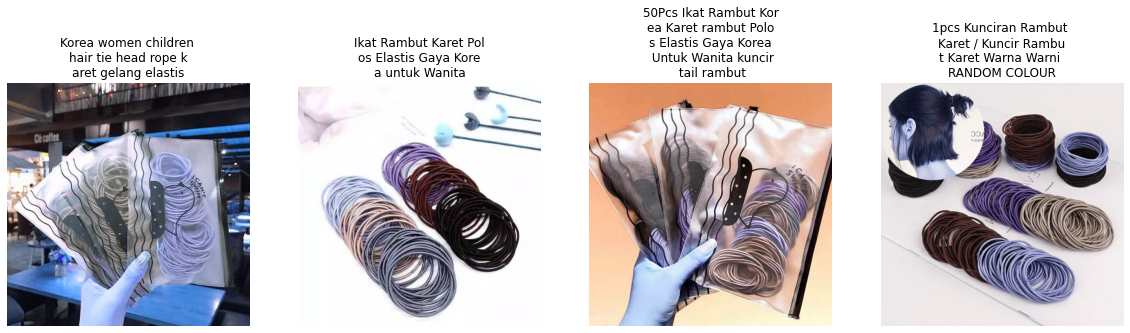

########################################
########################################
Top2 DUPLICATED ITEM : 159351600


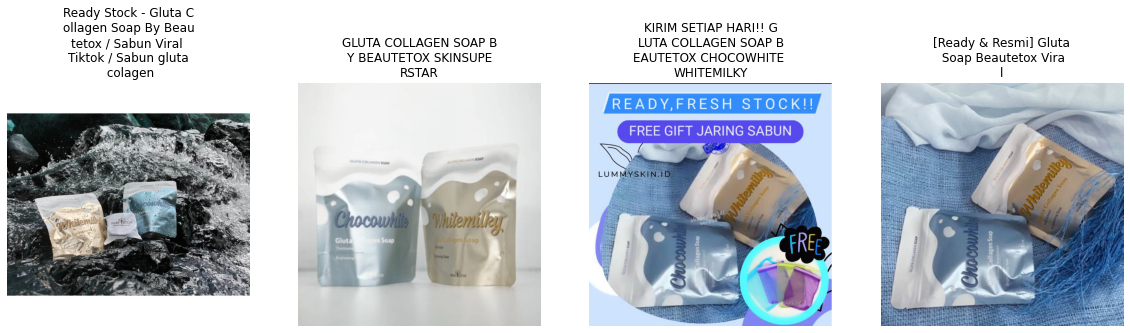

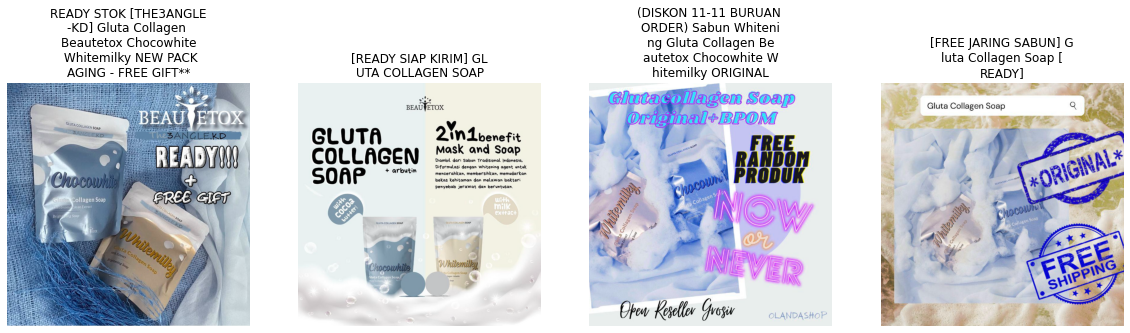

########################################
########################################
Top3 DUPLICATED ITEM : 562358068


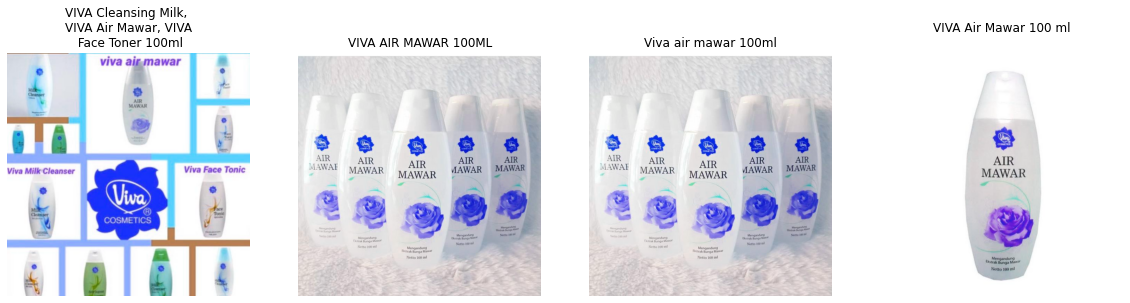

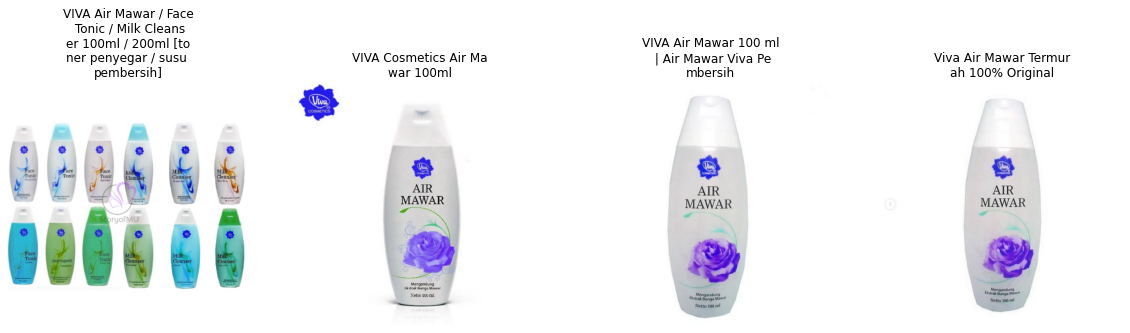

########################################
########################################
Top4 DUPLICATED ITEM : 3113678103


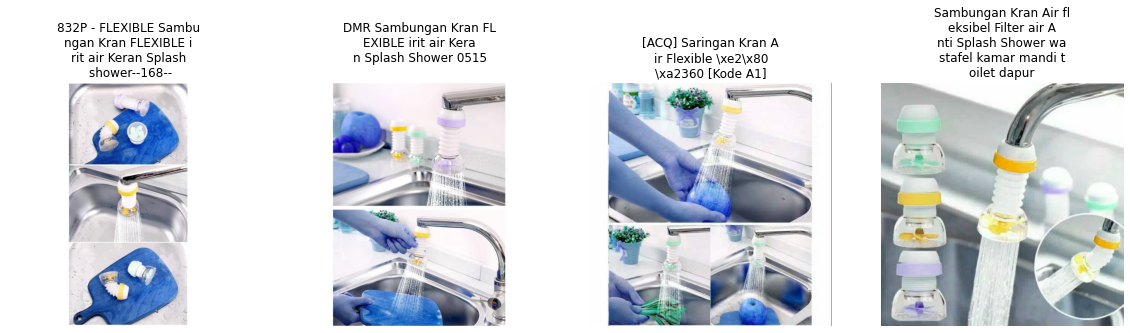

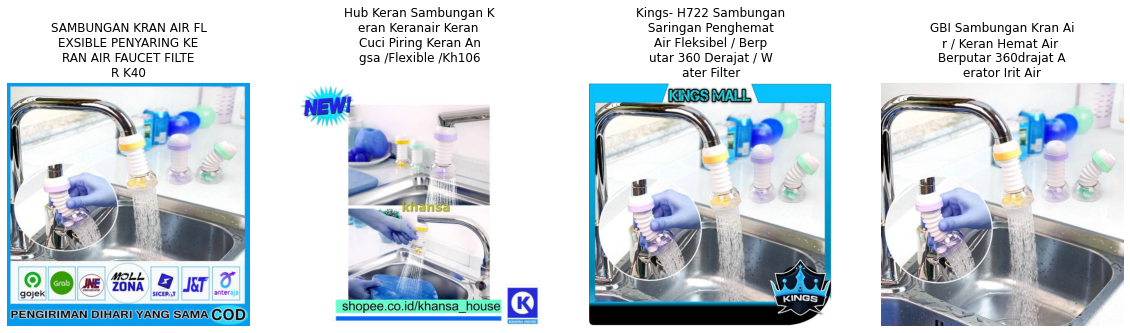

########################################
########################################
Top5 DUPLICATED ITEM : 1163569239


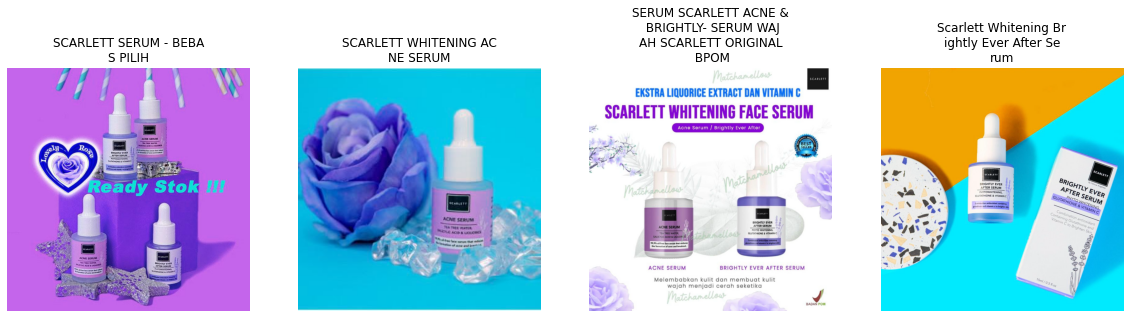

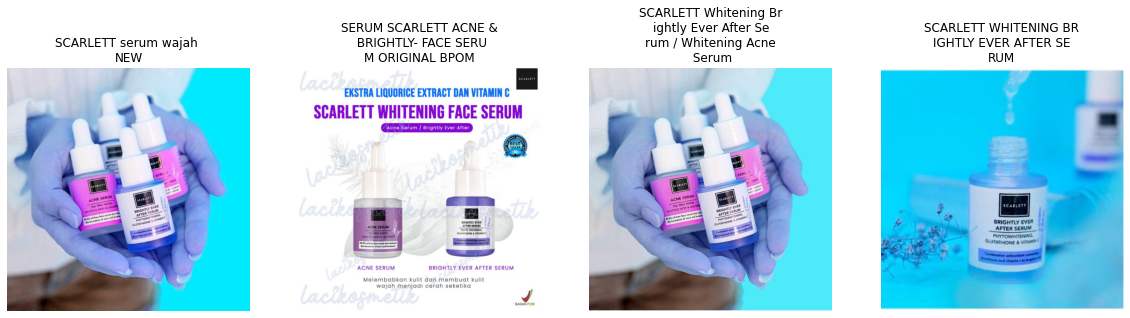

########################################


In [9]:
## Duplicated Item 의 TOP K 이미지를 display
for k in range(5):
    print('#'*40)
    unit_label = groups.index[k]
    print(f'Top{k+1} DUPLICATED ITEM : {unit_label}')
    displayDF(train[train.label_group == unit_label],rows=2,cols=4)
    print('#'*40)
    

### Find Similar Titles with RAPIDS

정답 라벨을 무시하고 오직 이미지의 title만 가지고 답을 도출해보자.

일단 RAPIDS cuML의 TFidfVectorizer 이용하여 text embedding을 한고 모든 타이틀을 단어집합의 워드임베딩으로 변환.

We will then compare one-hot-encodings with RAPIDS cuML KNN to find title's that are similar

In [10]:
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors
print('RAPIDS', cuml.__version__)

RAPIDS 0.18.0


In [11]:
#Load Train unto the gpu with cudf
train_gf = cudf.read_csv(path+'train.csv')
print('train shape is', train_gf.shape)
train_gf.head()

train shape is (34250, 5)


posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069

### Extract Text Embeddings with RAPIDS TfidfVectorizer

In [12]:
model = TfidfVectorizer(stop_words='english', binary=True)
text_embeddings = model.fit_transform(train_gf.title).toarray() #tfidfVector
print('text embeddings shape is', text_embeddings.shape)

text embeddings shape is (34250, 24939)


### Find Similar Titles with RAPIDS KNN

In [13]:
KNN = 50
model = NearestNeighbors(n_neighbors=KNN)
model.fit(text_embeddings)
distances, indices = model.kneighbors(text_embeddings) #distances가까운 array로 배열

In [14]:
train_gf.head()

posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069

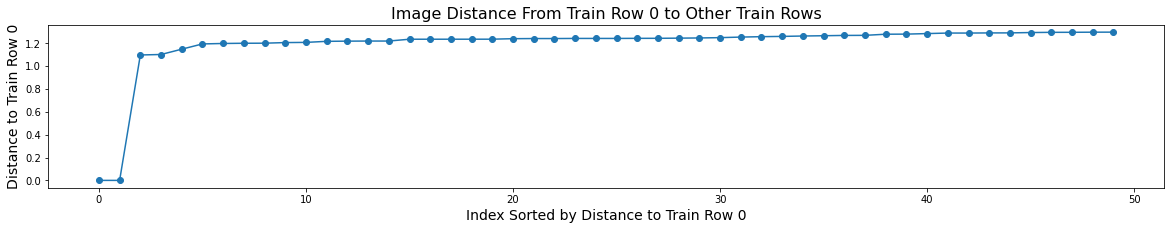

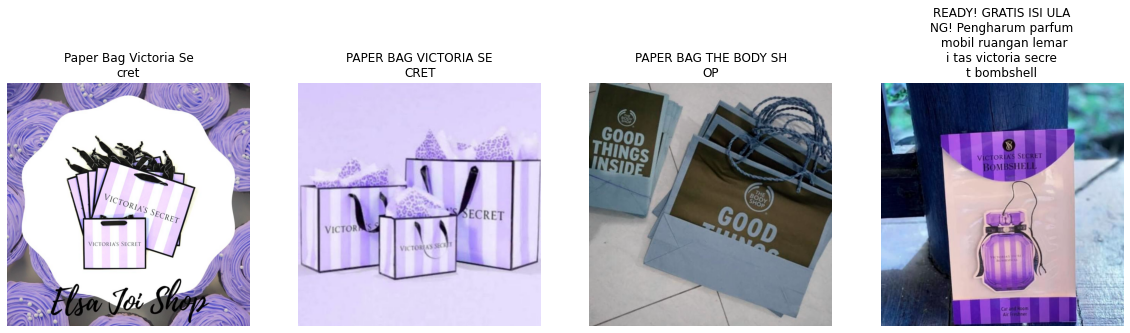

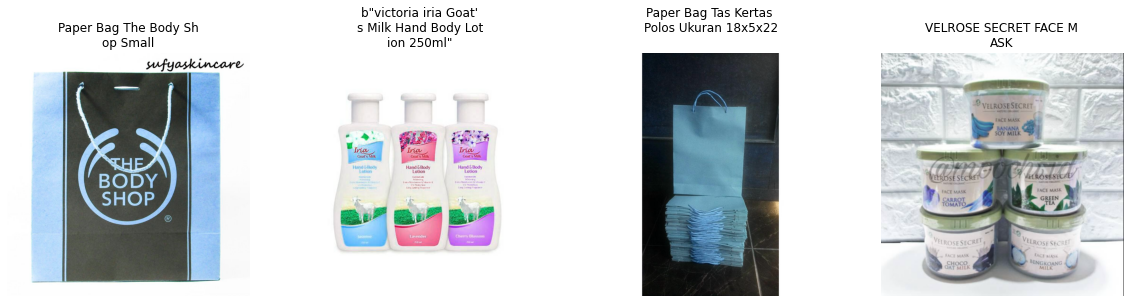

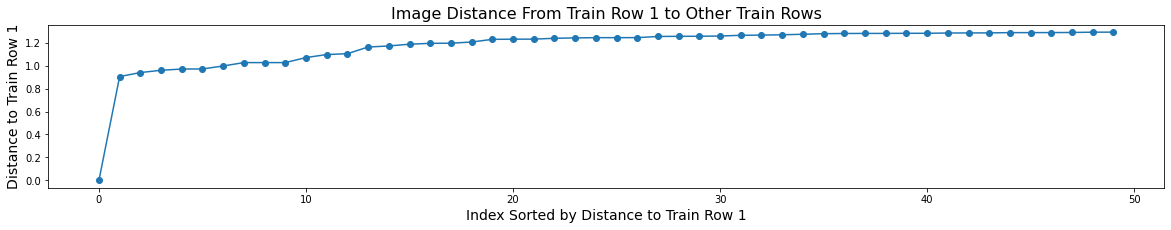

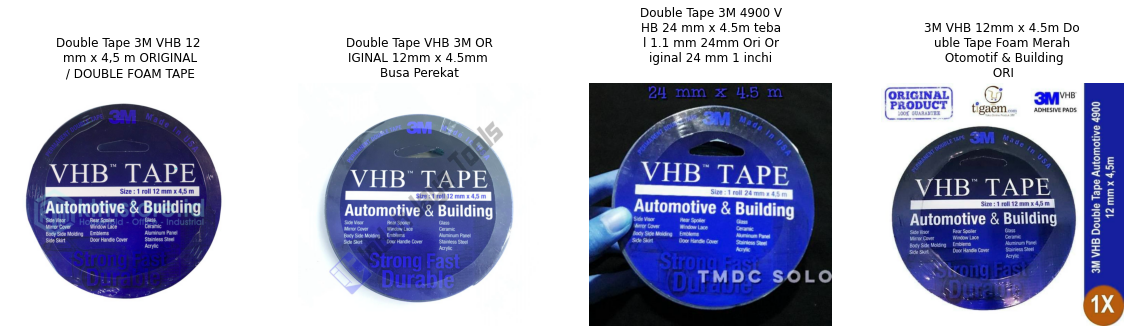

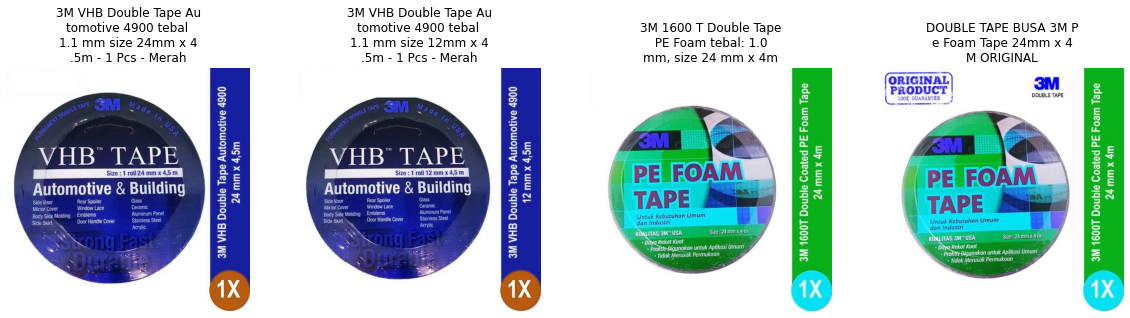

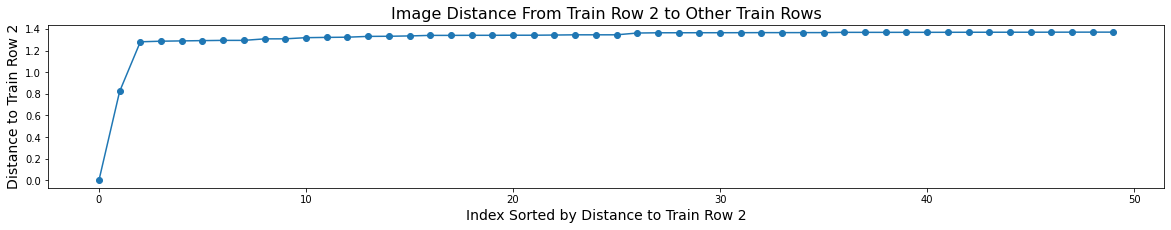

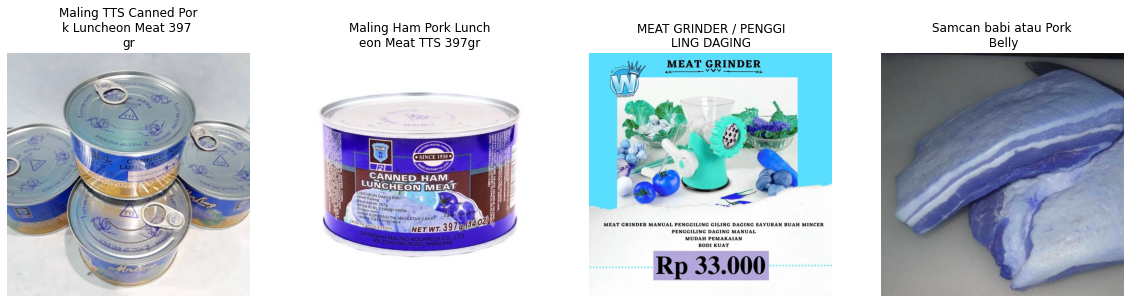

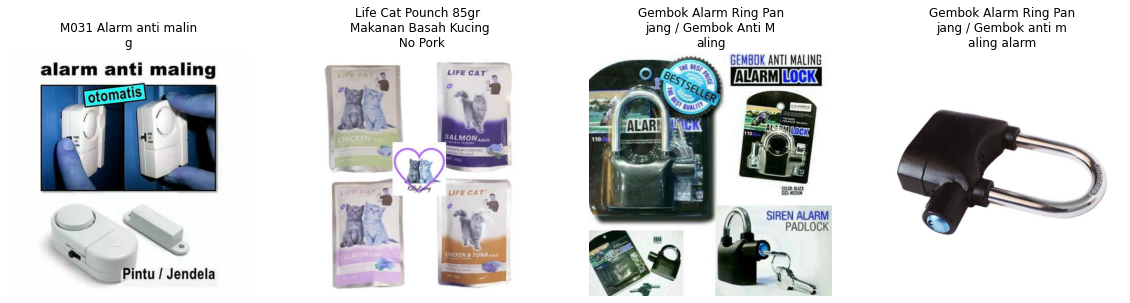

In [15]:
for k in range(3):
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(50),cupy.asnumpy(distances[k,]),'o-')
    plt.title('Image Distance From Train Row %i to Other Train Rows'%k,size=16)
    plt.ylabel('Distance to Train Row %i'%k,size=14)
    plt.xlabel('Index Sorted by Distance to Train Row %i'%k,size=14)
    plt.show()
    
    cluster = train.loc[cupy.asnumpy(indices[k,:8])] #거리순 상위 8개 
    displayDF(cluster, random=False, rows=2, cols=4)

### Test Data

In [16]:
test = pd.read_csv(path+'test.csv')
print(test.shape)
test.head()

(3, 4)


posting_id                                 image       image_phash  \
0  test_2255846744  0006c8e5462ae52167402bac1c2e916e.jpg  ecc292392dc7687a   
1  test_3588702337  0007585c4d0f932859339129f709bfdc.jpg  e9968f60d2699e2c   
2  test_4015706929  0008377d3662e83ef44e1881af38b879.jpg  ba81c17e3581cabe   

                                               title  
0  Edufuntoys - CHARACTER PHONE ada lampu dan mus...  
1  (Beli 1 Free Spatula) Masker Komedo | Blackhea...  
2   READY Lemonilo Mie instant sehat kuah dan goreng

In [17]:
sub = pd.read_csv(path+'sample_submission.csv')
print(sub.shape)
sub.head()

(3, 2)


posting_id          matches
0  test_2255846744  test_2255846744
1  test_3588702337  test_3588702337
2  test_4015706929  test_4015706929